### Seminar 9: exploration vs exploitation

In this seminar, we'll employ bayesian neural networks to facilitate exploration in contextual bandits.

__About bayesian neural networks:__
  * A post on the matter - [url](http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/)
  * Theano+PyMC3 for more serious stuff - [url](http://pymc-devs.github.io/pymc3/notebooks/bayesian_neural_network_advi.html)
  * Same stuff in tensorflow - [url](http://edwardlib.org/tutorials/bayesian-neural-network)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In this seminar, we're going to solve a toy contextual bandit problem
* 60-dimensional states
* 10 actions
* rewards between 0 and 1

Instead of actually running on a stream of data, we're gonna emulate it with samples from dataset.

In [2]:
all_states = np.load("all_states.npy")
action_rewards = np.load("action_rewards.npy")

state_size = all_states.shape[1]
n_actions = action_rewards.shape[1]
print ("%id states, %i actions"%(state_size,n_actions))

60d states, 10 actions


In [3]:
import theano, theano.tensor as T
import lasagne
from lasagne import init
from lasagne.layers import *
import bayes
as_bayesian = bayes.bbpwrap(bayes.NormalApproximation(std=0.1))
BayesDenseLayer = as_bayesian(DenseLayer)
#similar: BayesConv2DLayer = as_bayesian(Conv2DLayer)

In [4]:
class Bandit:
    """a bandit with bayesian neural net"""
    def __init__(self, state_size=state_size, n_actions=n_actions):
        
        #input variables
        input_states = T.matrix("states")
        target_actions = T.ivector("actions taken")
        target_rewards = T.vector("rewards")
        
        self.total_samples_seen = theano.shared(np.int32(0), "number of training samples seen so far")
        
        batch_size = target_actions.shape[0]

        
        ###
        #network body
        inp = InputLayer((None, state_size), name='input')
        hid = BayesDenseLayer(inp, 128)
        out = BayesDenseLayer(hid, n_actions)

        ###
        #prediction
        prediction_all_actions = get_output(out, inputs=input_states)
        self.predict_sample_rewards = theano.function([input_states], prediction_all_actions)

        ###
        #Training

        #select prediction for target action
        prediction_target_actions = prediction_all_actions[T.arange(batch_size), target_actions]

        #loss = negative log-likelihood (mse) + KL
        negative_llh = T.sum((prediction_target_actions - target_rewards)**2) 
        
        kl = bayes.get_var_cost(out) / (self.total_samples_seen+batch_size)
        
        loss = (negative_llh + kl)/batch_size

        self.weights = get_all_params(out, trainable=True)
        self.out = out

        #gradient descent
        updates = lasagne.updates.adam(loss, self.weights)
        
        #update counts
        updates[self.total_samples_seen] = self.total_samples_seen + batch_size.astype('int32')
        
        self.train_step = theano.function([input_states, target_actions, target_rewards],
                                          [negative_llh, kl],
                                          updates=updates,
                                          allow_input_downcast=True)
    
    
    def sample_prediction(self, states, n_samples=1):
        """Samples n_samples predictions for rewards,
        
        :returns: tensor [n_samples,state_i,action_i]
        """
        assert states.ndim==2, "states must be 2-dimensional"
        
        return np.stack([self.predict_sample_rewards(states) for _ in range(n_samples)])
    
    
    epsilon = 0.25
    
    def get_action(self, states):
        """
        Picks action by 
        - with p=1-epsilon, taking argmax of average rewards
        - with p=epsilon, taking random action
        This is exactly e-greedy policy.
        """
        
        reward_samples = self.sample_prediction(states, n_samples=100)
        #^-- samples for rewards, shape = [n_samples,n_states,n_actions]
        
        best_actions = reward_samples.mean(axis=0).argmax(axis=-1)
        #^-- we take mean over samples to compute expectation, then pick best action with argmax 
        
        random_actions = np.random.choice(n_actions, size=states.shape[0])
        
        chosen_actions = best_actions if np.random.rand() > self.epsilon else random_actions
        
        return chosen_actions
    
    def train(self, states,actions, rewards,n_iters=10):
        """
        trains to predict rewards for chosen actions in given states
        """
        
        loss_sum = kl_sum = 0
        for _ in range(n_iters):
            loss, kl = self.train_step(states, actions, rewards)
            loss_sum += loss
            kl_sum += kl

            
        return loss_sum/n_iters, kl_sum/n_iters

### Train the bandit

We emulate infinite stream of data and pick actions using agent's get_action function.

In [5]:
bandit = Bandit() #create your bandit

rewards_history = []

In [6]:
def get_new_samples(states,action_rewards,batch_size=10):
    """samples random minibatch, emulating new users"""
    
    batch_ix = np.random.randint(0, len(states), batch_size)
    return states[batch_ix], action_rewards[batch_ix]

iteration #990	mean reward=0.720	mse=0.106	kl=0.008


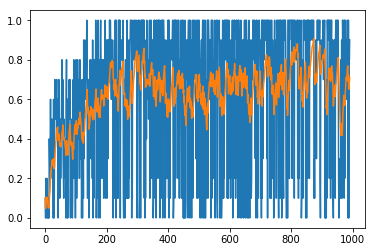

Q(s,a) std: 0.013;0.000;0.000;0.104;0.016;0.000;0.015;0.000;0.024;0.000
correct 6


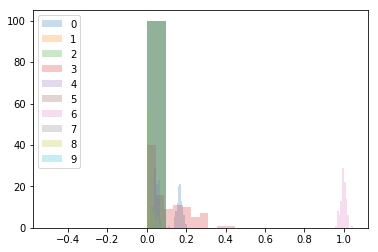

In [7]:
from IPython.display import clear_output
from pandas import ewma

batch_size=10 #10 new users

for i in range(1000):
    ###
    #new data
    b_states, b_action_rewards = get_new_samples(all_states, action_rewards, batch_size)
    
    ###
    #pick actions
    b_actions = bandit.get_action(b_states)
    
    ###
    #rewards for actions agent just took
    b_rewards = b_action_rewards[np.arange(batch_size), b_actions]
    
    ###
    #train bandit
    mse, kl = bandit.train(b_states, b_actions, b_rewards, n_iters=100)
    
    rewards_history.append(b_rewards.mean())
    
    if i%10 ==0:
        clear_output(True)
        print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f"%(i,np.mean(rewards_history[-10:]),mse,kl))
        plt.plot(rewards_history)
        plt.plot(ewma(np.array(rewards_history), alpha=0.1))
        plt.show()
        samples = bandit.sample_prediction(b_states[:1], n_samples=100).T[:,0,:]
        for i in range(len(samples)):
            plt.hist(samples[i], alpha=0.25, label=str(i))
            plt.legend(loc='best')
        
        print('Q(s,a) std:', '; '.join(list(map('{:.3f}'.format,np.std(samples, axis=1)))))
        print('correct', b_action_rewards[0].argmax())
        plt.show()

## Better exploration

You will now implement the two exploration strategies from the lecture.

In [8]:
#then implement it and replace bandit = Bandit() above with ThompsonBandit()
class ThompsonBandit(Bandit):
    def get_action(self,states):
        """
        picks action based by taking _one_ sample from BNN and taking action with highest sampled reward (yes, that simple)
        This is exactly thompson sampling.
        """
        <your code>
        
        return <your code>


SyntaxError: invalid syntax (<ipython-input-8-1e2e75a93001>, line 8)

In [ ]:
#then implement it and replace bandit = Bandit() above with UCBBandit()

class UCBBandit(Bandit):
    q = 90
    def get_action(self,states):
        """
        Compute q-th percentile of rewards P(r|s,a) for all actions
        Take actions that have highest percentiles.
        
        This implements bayesian UCB strategy
        """
        
        <Your code here>
        
        return <actions with bayesian ucb>


In [ ]:
bandit = <UCBBandit or ThompsonBandit>
#<maybe change parameters>

rewards_history = []

In [ ]:
from IPython.display import clear_output
from pandas import ewma

batch_size=10 #10 new users

for i in range(1000):
    ###
    #new data
    b_states, b_action_rewards = get_new_samples(all_states, action_rewards, batch_size)
    
    ###
    #pick actions
    b_actions = bandit.get_action(b_states)
    
    ###
    #rewards for actions agent just took
    b_rewards = b_action_rewards[np.arange(batch_size), b_actions]
    
    ###
    #train bandit
    mse, kl = bandit.train(b_states, b_actions,b_rewards, n_iters=100)
    
    rewards_history.append(b_rewards.mean())
    
    if i%10 ==0:
        clear_output(True)
        print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f"%(i,np.mean(rewards_history[-10:]),mse,kl))
        plt.plot(rewards_history)
        plt.plot(ewma(np.array(rewards_history),alpha=0.1))
        plt.show()
        samples = bandit.sample_prediction(b_states[:1],n_samples=100).T[:,0,:]
        for i in range(len(samples)):
            plt.hist(samples[i],alpha=0.25,label=str(i))
            plt.legend(loc='best')
        print('Q(s,a) std:', ';'.join(list(map('{:.3f}'.format,np.std(samples,axis=1)))))
        print('correct',b_action_rewards[0].argmax())
        plt.show()

### Experience replay

Our value-based bandit algorithm is off-policy, so we can train it on actions from a different policy.

For example, the bandit will need much less interactions to converge if you train it on past experiences. You can also pre-train it on any data you already have.

In [ ]:
class ReplayBandit(Bandit): #or your preferred exploration type
    """A bandit that trains not on last user interactions but on random samples from everything it saw"""
    experience_buffer=[]
    
    <Your code here. You will at least need to modify train function>

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```